In [209]:
import pandas as pd
import networkx as nx
import torch


In [210]:
print(torch.__version__)


1.9.1+cu111


In [211]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [212]:

dataset = r"C:\Users\vansh\AI and ML reading material\GraphGAN_Project\GraphGAN\bio-grid-human\bio-grid-human_train.txt"
df = pd.read_csv(dataset,
                sep = '\t',
                names = ["NodeIDfrom", "NodeIDto"],
                )
#create the graph networkx object from the above dataframe

G = nx.from_pandas_edgelist(df = df,
                             source = "NodeIDfrom",
                             target = "NodeIDto",
                             create_using=nx.Graph())
len(G)

9408

In [213]:
import numpy as np

def read_embeddings(filename, n_node, n_embed):
    """read pretrained node embeddings
    """

    with open(filename, "r") as f:
        lines = f.readlines()[1:]  # skip the first line
        rng = np.random.default_rng(seed=42)
        embedding_matrix = rng.standard_normal(size = (n_node, n_embed))
        for line in lines:
            emd = line.split()
            embedding_matrix[int(emd[0]), :] = str_list_to_float(emd[1:])
        return embedding_matrix

def str_list_to_float(str_list):
    return [float(item) for item in str_list]
filename = r"C:\Users\vansh\AI and ML reading material\GraphGAN_Project\GraphGAN\test_embeddings.emb"
X = read_embeddings(filename=filename,
                                     n_node = 9436,
                                     n_embed = 50)
X[4095], X.shape 

(array([ 0.04428641,  0.01664046,  1.29711616,  0.90526241, -0.21166077,
         0.40907905,  0.50860739,  0.02826489, -0.40373492, -0.3071233 ,
         0.2036521 , -0.13330054, -0.73106694, -0.44571012, -0.32779747,
         0.63002121,  0.25185969, -0.85279828, -0.61209828, -0.70513356,
         0.04547041,  0.2914018 , -0.51782751, -0.66512847,  0.52263975,
         0.07702284,  0.18406558, -0.35518035, -0.46163401,  0.13852245,
        -0.21319886,  0.04984829, -0.13761635, -0.79279733,  1.03973246,
        -0.25569507,  0.35949531, -0.16053431, -0.34106565, -0.61736548,
         0.15605371, -0.14700042,  0.31443897,  0.72904819,  0.86358976,
         0.07801782, -0.38824505,  0.22436079, -0.03544478,  0.43348771]),
 (9436, 50))

In [214]:
rng = np.random.default_rng(seed = 42)

k=3
X = np.array(X)
node_embed_dim = 50
centroid = rng.standard_normal(size = (k, node_embed_dim))

In [215]:
type(centroid), type(X)

(numpy.ndarray, numpy.ndarray)

In [216]:

#K-Means Algorithm for node embeddings
#the embediddings are 1xd dimensional.
class KMeansNodeClustering:

  def __init__(self, X, k, node_embed_dim):
      self.k = k #k is the number of cluster centres
      self.X = X #dataset consisting of node embeddings
      self.node_embed_dim = node_embed_dim #dimensions of node embeddings.
      self.centroid = None #these will be the centres of our distribution

  @staticmethod
  def euclidean_measure(centroid, node_embed):  # calculates the distance of the k-dimensional node from the centre
      return np.sqrt(np.sum((centroid - node_embed)**2, axis=1))

  def dimensional_mean(cluster_num, node_embed_dim, cluster_indices, cluster_centres): #calculates the mean of of the arrays, dimension-wise
        axis_centre = np.zeros(node_embed_dim)
        for i in range(node_embed_dim):
            y = 0
            tup = cluster_indices[cluster_num].shape
            shape = tup[0]
            for x in range(shape):
                y += X[cluster_indices[cluster_num][x]][0][i]
            mean = np.mean(y)
            axis_centre[i] += mean
        axis_centre = axis_centre/np.linalg.norm(axis_centre)
        return cluster_centres.append(axis_centre)

  def fit(self, max_iterations = 200):
      rng = np.random.default_rng(seed = 69)
      self.centroid = rng.standard_normal(size = (self.k, self.node_embed_dim))
      self.centroid  = (self.centroid)/(np.max(self.centroid))
      for _ in range(max_iterations):
          y = []

          for node_embed in self.X:
                distance = KMeansNodeClustering.euclidean_measure(node_embed = np.array(node_embed),
                                                                  centroid = centroid)
                cluster_num = np.argmin(distance)
                y.append(cluster_num)

          y = np.array(y) #stores the clustur number each of the nodes belong to

          cluster_indices = [] #to know which node belongs to which cluster

          for i in range(self.k):
                cluster_indices.append(np.argwhere(y == i)) #returns every node which belongs to the same cluster
          cluster_indices = np.array(cluster_indices, dtype = object)
          cluster_centres = [] #stores the centres of the clusters

          for j, indices in enumerate(cluster_indices): #cluster_indices contains the cluster numbers and the indices that belong to a particular cluster
                #i = cluster number
                #indices = indices of the nodes that belong to i.
                if len(indices) == 0:
                    cluster_centres.append(self.centroid[i])
                else:
                    KMeansNodeClustering.dimensional_mean(
                                                          cluster_num = j,
                                                          node_embed_dim=node_embed_dim,
                                                          cluster_indices = cluster_indices,
                                                          cluster_centres=cluster_centres)

          self.centroid = np.array(cluster_centres)
          y = np.array(y)
      return y, cluster_indices




In [217]:
clustered_nodes = KMeansNodeClustering(X = X,
                                       k = k,
                                       node_embed_dim = node_embed_dim)
#cluster_indices_id stores the number_id of the clusters each embeddings is related to
#cluster_indices stores all the nodes that belong to one particular cluster, for all the clusters.
cluster_indices_id, cluster_indices = clustered_nodes.fit()


In [218]:
centroid_array = clustered_nodes.centroid #contains the centroids of all the clusteres.
centroid_array

array([[-2.60521921e-01, -2.25079719e-01,  1.70703246e-01,
         2.93160470e-01, -1.80419696e-01, -9.73798491e-02,
         1.91736804e-01,  3.50692681e-01, -1.66105641e-02,
        -1.17406508e-01, -3.08984803e-02, -2.00355734e-01,
         4.00088408e-02, -2.32149910e-02, -2.95282030e-03,
         1.49935722e-01, -3.74627384e-03, -1.66938991e-01,
        -1.40780435e-01, -4.33455600e-02,  1.49278451e-02,
         1.08811022e-01,  2.02408853e-01, -5.35639307e-02,
         4.20682516e-02,  2.74587138e-02,  1.38631710e-01,
        -1.21638137e-02, -4.86514792e-02, -3.92661541e-02,
         4.42868829e-02,  1.14571170e-02, -9.24602228e-02,
        -2.14585393e-02,  1.58628259e-01,  8.40528614e-02,
         2.63472009e-02,  1.55553757e-01,  4.34382282e-02,
        -1.48067438e-01,  2.78264245e-01, -1.80117398e-01,
         9.64283552e-02,  1.39813482e-01,  1.60654962e-01,
         1.60831360e-01, -1.88356166e-01, -5.54736059e-02,
        -1.54537725e-02,  1.79757477e-01],
       [-2.41

In [219]:
torch.zeros(size=[5])

tensor([0., 0., 0., 0., 0.])

In [220]:
cluster_indices = np.array(cluster_indices, dtype=object)
cluster_indices_array = np.array([torch.tensor(np.squeeze(cluster_indices[0], axis = 1)),
                                  torch.tensor(np.squeeze(cluster_indices[1], axis = 1)),
                                  torch.tensor(np.squeeze(cluster_indices[2], axis = 1)),
                                  ], dtype = object)


cluster_indices_array

C:\Users\vansh\AppData\Local\Temp\ipykernel_7040\1584236110.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  cluster_indices_array = np.array([torch.tensor(np.squeeze(cluster_indices[0], axis = 1)),


array([tensor([   0,    1,    6,  ..., 9432, 9434, 9435]),
       tensor([   2,    3,    4,  ..., 9423, 9425, 9433]), tensor([4332])],
      dtype=object)

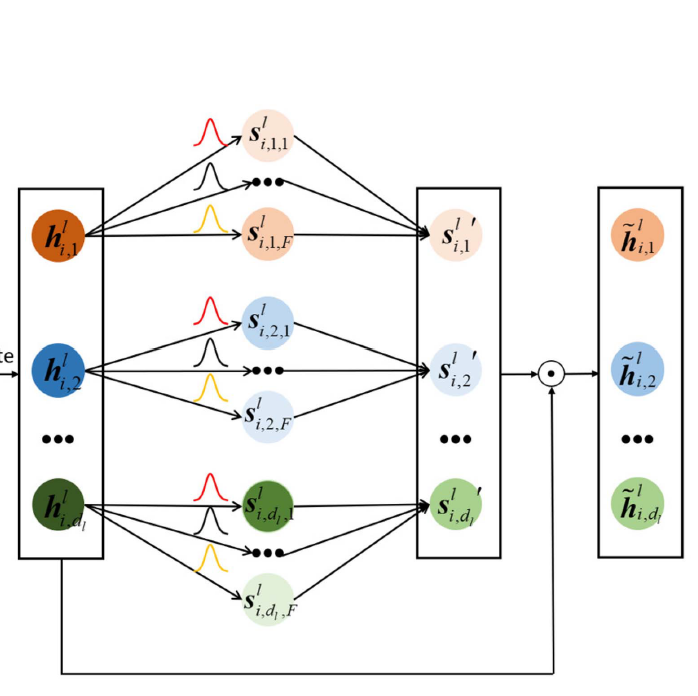

In [221]:
class FuzzyLayer:
    """
    This is the parent class which will contain variables for for Antecedant, Inference and Consequent classes.

    Args:
        X: The dataset which contains all the embeddings. shape(no_of_nodes, node_embed_dim)
        centroid_array: contains all the centroids of all the clusters. shape(no_of_clusters, node_embed_dim)
        cluster_indices_array: contains all the indices that belong to one particular cluster. shape(no_of_clusters, *number_of_indices_per_cluster*)
                                                                                               number_of_indices_per_cluster varies therefore it has no particular shape
    """

    def __init__(self, X, centroid_array, cluster_indices_array):
        self.X = torch.tensor(X, device=device, dtype=torch.float64)
        self.centroid_array = torch.tensor(centroid_array, device=device, dtype=torch.float64)
        self.cluster_indices_array = cluster_indices_array

class Antecedant(FuzzyLayer):
    """
    Antecedant part of the fuzzy logic system, it gives us membership functions the node embeddings.
    """
    def __init__(self, X, centroid_array, cluster_indices_array):
        super().__init__(X, centroid_array, cluster_indices_array)


    def dot_product(self):                                          #claculates the dot product of the embeddings and the centroids
        dot_products = torch.zeros(size = (self.X.shape[0], k))
        row =0
        for node_embed in X:
            for i in range(self.centroid_array.shape[0]):
                y = torch.matmul(node_embed, self.centroid_array[i])
            dot_products[row][i] += y
            row +=1
        return dot_products                                         #returns the array of dot products of each embedding with each of the k-centroids.
                                                                        #size = (number_of_nodes, number_of_cluster)

    def get_points(self, cluster_num, embed_axis):
        shape = self.cluster_indices_array[cluster_num].shape[0]                                                          #we specify which cluster's which embedding axis is required.
        points = torch.zeros(size = [shape], device=device)                                #stores the points corresponding to the cluster_num and embed_axis.
        cluster_ids = self.cluster_indices_array[cluster_num].to(device)
        for id in range(shape):
            points[id] += self.X[cluster_ids[id]][embed_axis]
        return points

    def get_mean(self, cluster_num, embed_axis):
        return self.centroid_array[cluster_num][embed_axis].to(device)

    def get_variance(self, cluster_num, embed_axis):
        points = self.get_points(cluster_num = cluster_num,
                                 embed_axis = embed_axis)
        y=0
        mean = self.get_mean(cluster_num = cluster_num,
                             embed_axis = embed_axis)
        shape = 0
        for x in tuple(points.shape):
            shape = x
        for i in range(shape):
            y +=  (mean - points[i])**2
            y = y/(points.shape[0])
        variance = torch.sqrt(y)
        return variance

    def get_variance_tensor(self, embed_axis):
        variance_tensor = torch.zeros(size = [k], device=device)
        for i in range(k):
            variance = self.get_variance(cluster_num = i,
                                         embed_axis = embed_axis)
            variance_tensor[i] += variance
        #variance_tensor = variance_tensor/np.linalg.norm(variance_tensor)
        return variance_tensor

    def gaussianMF(self, cluster_num, embed_axis, element): #element is basically the value of embeddings at each dimension in each of the node_embeddings
        mean = self.get_mean(cluster_num = cluster_num,
                             embed_axis = embed_axis)
        variance_tensor = self.get_variance_tensor(embed_axis = embed_axis)
        if(variance_tensor[cluster_num] != 0):
            gaussian = (element - mean)**2/(2*((variance_tensor[cluster_num])**2))
        else:
            return 0
        return torch.exp(-gaussian)

    def get_membership_array(self, embed_axis):
        membership_array = torch.zeros(size = [node_embed_dim, self.X.shape[0], k], device=device) #(50, 5242, 5)
        for node_embed_num in range(self.X.shape[0]):
            for i in range(k):
                membership = self.gaussianMF(cluster_num = i,
                                             embed_axis = embed_axis,
                                             element = X[node_embed_num][embed_axis])
                membership_array[embed_axis][node_embed_num][i] += membership
        return membership_array[embed_axis]





In [222]:
b = Antecedant(X = X,
               centroid_array = centroid_array,
               cluster_indices_array = cluster_indices_array)

In [223]:
for i in range(node_embed_dim):
    variance_tensor = b.get_variance_tensor(embed_axis = i)
    print(variance_tensor)

tensor([0.0270, 0.0023, 0.0016], device='cuda:0')
tensor([0.0114, 0.0064, 0.7385], device='cuda:0')
tensor([0.0296, 0.0059, 0.2614], device='cuda:0')
tensor([0.0113, 0.0080, 0.9415], device='cuda:0')
tensor([0.0391, 0.0043, 0.0574], device='cuda:0')
tensor([4.6702e-04, 7.0929e-03, 2.9482e+00], device='cuda:0')
tensor([0.0179, 0.0014, 0.6152], device='cuda:0')
tensor([0.0191, 0.0034, 0.7519], device='cuda:0')
tensor([0.0150, 0.0041, 0.5509], device='cuda:0')
tensor([0.0192, 0.0052, 0.6882], device='cuda:0')
tensor([0.0091, 0.0017, 0.5652], device='cuda:0')
tensor([0.0035, 0.0057, 0.9689], device='cuda:0')
tensor([0.0082, 0.0032, 1.0196], device='cuda:0')
tensor([0.0092, 0.0091, 0.9068], device='cuda:0')
tensor([0.0112, 0.0038, 0.0158], device='cuda:0')
tensor([1.1591e-02, 1.3901e-03, 2.0115e+00], device='cuda:0')
tensor([0.0113, 0.0014, 0.7687], device='cuda:0')
tensor([0.0204, 0.0061, 0.0195], device='cuda:0')
tensor([0.0128, 0.0001, 0.0789], device='cuda:0')
tensor([0.0068, 0.0083, 0.

In [224]:
membership_array = []
for embed_axis in range(node_embed_dim):
    mem_array_per_axis = b.get_membership_array(embed_axis = embed_axis)
    membership_array.append(mem_array_per_axis)
membership_array = np.array(membership_array, dtype = object)
membership_array

KeyboardInterrupt: 

In [ ]:
G.number_of_nodes()

7192

In [ ]:
class Consequent(FuzzyLayer):
    """
    This class generates the the crisp embeddings using the membership that were generated using the ANtecedant class.

    Essentially, we were able to fuzzify each of the embeddings for each of the node. We clustered the nodes, found 5 centroids, found out
    membership for each of the embedding and now we look to use that membership to output crisp memberships.

    To do that we will generate 50 sets with 50 variances and we will treat it as the consequent fuzzy set from which crisp output is generated.
    """
    def __init__(self, X, centroid_array, cluster_indices_array):
        super().__init__(X, centroid_array, cluster_indices_array)

    def get_average_membership_array(self, membership_array):
        return np.mean(membership_array, axis = 2) #shape = (50, 5242)

    def get_embed_axis_mean(self):
        a = X.transpose() #shape = (50, 5242)
        return np.mean(a, axis = 1) #shape = (50,)

    def get_embed_axis_variance(self):
        a = self.X.transpose()
        mean = self.get_embed_axis_mean()
        variance = np.zeros(shape = node_embed_dim)
        for i in range(node_embed_dim):
            x = np.sqrt(np.mean((a[i] - mean[i])**2))
            variance[i] += x
        return variance #shape = (50,)

    def get_crisp_embeddings(self, average_membership_array): #average_membership_array.shape = (50, 5242)
        a = X.transpose()
        mean = self.get_embed_axis_mean()
        variance = self.get_embed_axis_variance()
        new_X = np.zeros(shape = (node_embed_dim, self.X.shape[0]))
        for i in range(node_embed_dim):
            for j in range(self.X.shape[0]):
                if average_membership_array[i][j] == 0:
                    new_X[i][j] = a[i][j]
                else:
                    b = -1*np.log(average_membership_array[i][j])
                    if(a[i][j] < 0):
                        b = -1*np.sqrt(b)
                    else:
                        b = np.sqrt(b)
                    b = b*variance[i] + mean[i]
                    new_X[i][j] = b
        new_X = new_X.transpose()
        new_X.shape
        #new_X = new_X/np.linalg.norm(new_X, axis = 0)
        return new_X





In [ ]:
c = Consequent(X = X,
               centroid_array=centroid_array,
               cluster_indices_array = cluster_indices_array)

In [ ]:
average_membership = c.get_average_membership_array(membership_array = membership_array)
average_membership 



In [ ]:
crisp = c.get_crisp_embeddings(average_membership_array = average_membership)
norm = np.linalg.norm(crisp, axis = 1)
print(norm.shape)
for i in range(crisp.shape[0]):
    crisp[i] = crisp[i]
crisp


In [ ]:
import numpy as np
crisp = np.random.normal(size=(7393, 50))
new_X = []
for node in G.nodes():
    new_X.append(crisp[node])
new_X = np.array(new_X)

In [ ]:
index = np.array(G.nodes()).reshape(-1, 1)
index

array([[5408],
       [4299],
       [ 578],
       ...,
       [7086],
       [4665],
       [6832]])

In [ ]:
import os
embedding_filename = r"C:\Users\vansh\AI and ML reading material\GraphGAN_Project\GraphGAN\Results\new.txt"
embeddings = crisp
index = np.array(G.nodes()).reshape(-1, 1)
embedding_matrix = np.hstack([index, embeddings])
embedding_list = embedding_matrix.tolist()
embedding_str = [str(int(emb[0])) + " " + " ".join([str(x) for x in emb[1:]]) + "\n"
                  for emb in embedding_list]
with open(embedding_filename, "w+") as f:
    lines = [str(G.number_of_nodes()) + "\t" + str(node_embed_dim) + "\n"] + embedding_str
    f.writelines(lines)
